In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

/opt/notebooks/cerebrum/CISS2022/git/CISS/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-01 12:59:53.182148: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-01 12:59:53.182168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

### Загрузка из оригинальных excel файлов

Тут надо покрасивее, но пока нет времени

In [7]:
data_test = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Attack_v0.xlsx', 
                          skiprows=1, 
                          parse_dates=True,
                          index_col=[0])
data_test = data_test.rename(columns={'Normal/Attack':'anomaly'})

In [8]:
data_test['anomaly'].value_counts()

Normal     395298
Attack      54584
A ttack        37
Name: anomaly, dtype: int64

In [9]:
data_test['anomaly'] = data_test['anomaly'].apply(lambda x: 0 if x=='Normal' else 1)

# исправление некорректного времени надо как то красивее, но нет пока времени на красоту
data_test.reset_index(inplace=True)
replace_idx = data_test[data_test[' Timestamp'] >= pd.to_datetime('2016-02-01')].index
data_test.loc[replace_idx,' Timestamp'] = data_test.loc[replace_idx,' Timestamp'].apply(pd.Timestamp.replace, month=1, day=2) 
data_test.index = data_test.pop(' Timestamp')

data_test.tail()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-02 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,0
2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0


In [10]:
data_test['anomaly'].value_counts()

0    395298
1     54621
Name: anomaly, dtype: int64

In [11]:
data_train = pd.read_excel('./SWAT/SWaT.A1 _ A2_Dec 2015/Physical/SWaT_Dataset_Normal_v1.xlsx', 
                          skiprows=1, 
                          parse_dates=True,
                          index_col=[0])

data_train.drop('Normal/Attack', axis=1, inplace=True)
data_train

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:30:00,0.000000,124.3135,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
2015-12-22 16:30:01,0.000000,124.3920,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
2015-12-22 16:30:02,0.000000,124.4705,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
2015-12-22 16:30:03,0.000000,124.6668,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
2015-12-22 16:30:04,0.000000,124.5098,1,1,1,251.9226,8.313446,312.7916,0.000000,1,...,0.000000,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-28 09:59:55,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.308619,2,1,250.817100,1.778105,189.8552,0.000128,1,1,1
2015-12-28 09:59:56,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,2,...,0.308619,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1
2015-12-28 09:59:57,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,2,...,0.308619,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1


In [12]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index([], dtype='object')

deleting constant features: ['P401', 'P404', 'P502', 'P601', 'P603']


### Загрузка из подготовленных CSV

In [6]:
df_train = pd.read_csv('./data/SWAT15_df_train.csv', index_col=[0], parse_dates=True)
df_train.head(3)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:30:00,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
2015-12-22 16:30:01,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1
2015-12-22 16:30:02,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.001538,0.001409,0.001664,0.0,1,9.100231,0.0,3.3485,0.000256,1


In [7]:
df_test = pd.read_csv('./data/SWAT15_df_test.csv', index_col=[0], parse_dates=True)
df_test.head(3)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,1.279621,0.735269,0.307786,2,250.8652,1.649953,189.5988,0.000128,1,0
2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,1.297554,0.735269,0.307786,2,250.8652,1.649953,189.6789,0.000128,1,0
2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,1.293967,0.735269,0.308619,2,250.8812,1.649953,189.6789,0.000128,1,0


In [8]:
summary = {}

## Подготовка train/test

In [9]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


## OC SVM

In [11]:
description='SWATDec15_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-01 13:09:49.928821: find saved model: ./saved_models/SWATDec15_svm_default, loading...


In [12]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWATDec15_svm_default
f1_score: 0.28
accuracy_score: 0.47
precision_score: 0.17
recall_score: 0.86


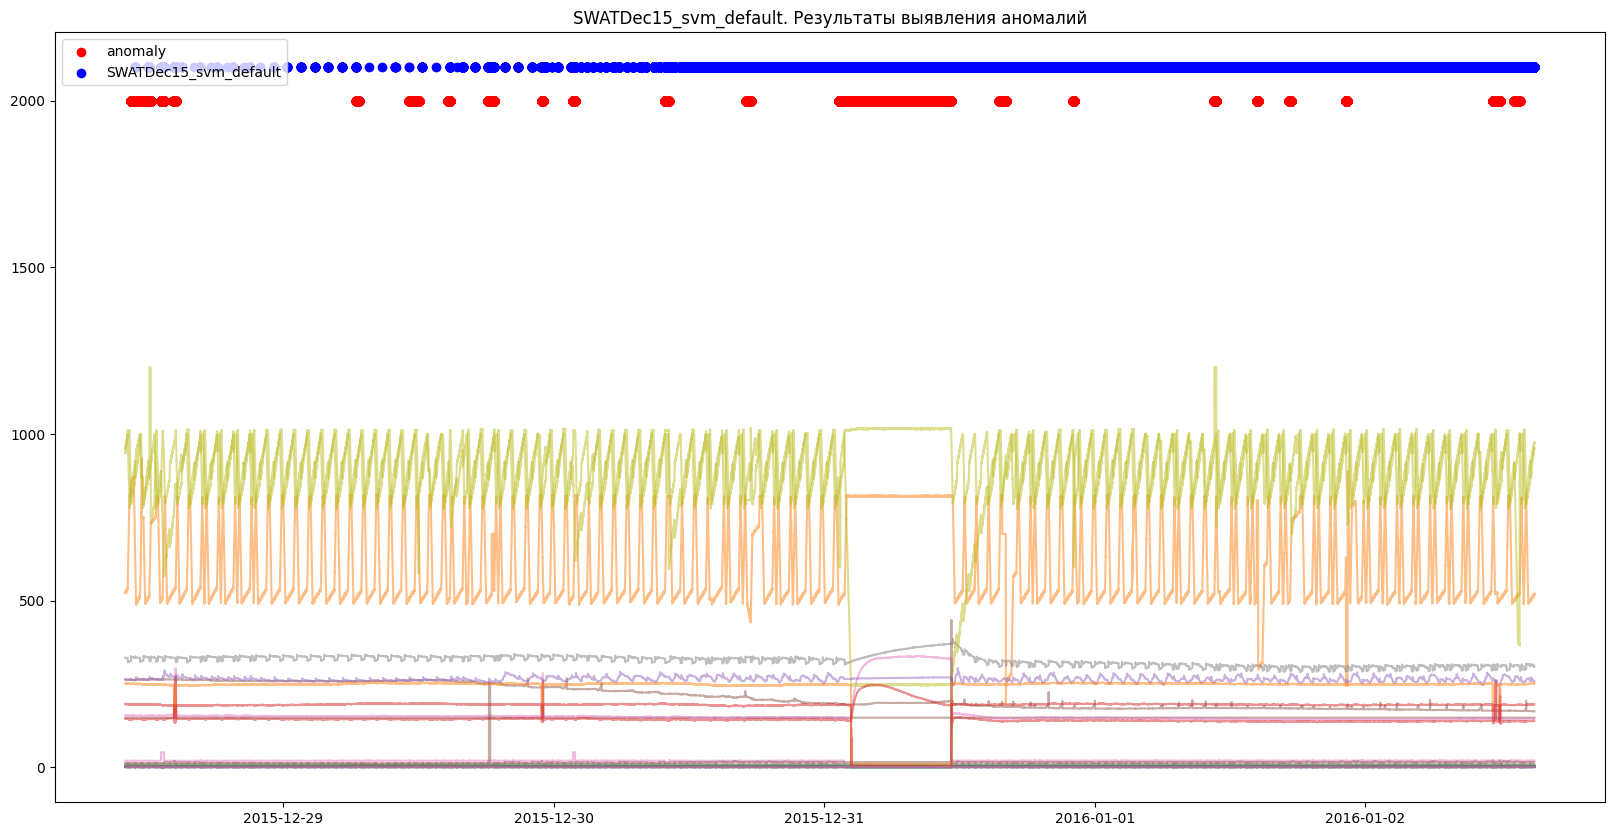

In [13]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-01 13:11:33.333147: find saved model: ./saved_models/SWATDec15_svm_minmax, loading...
SWATDec15_svm_minmax
f1_score: 0.26
accuracy_score: 0.37
precision_score: 0.15
recall_score: 0.89


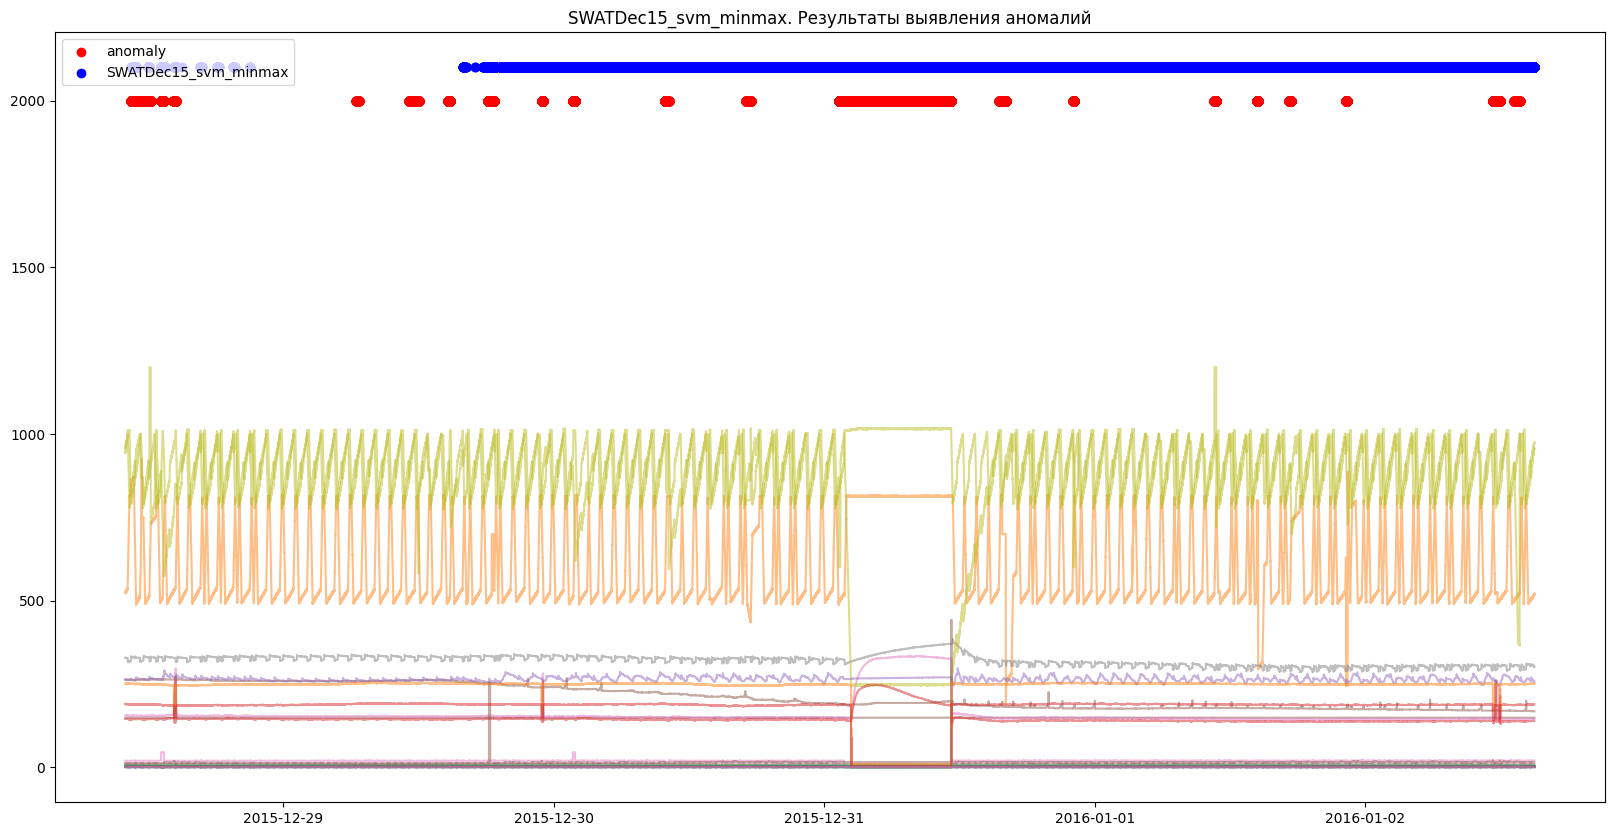

In [14]:
description='SWATDec15_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [15]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [16]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)


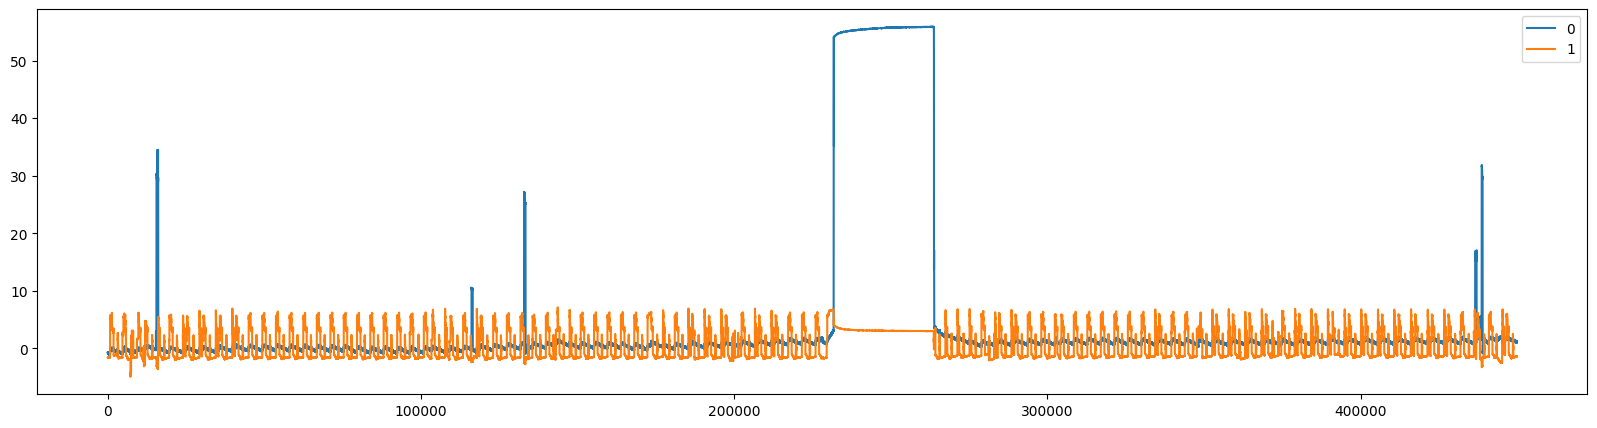

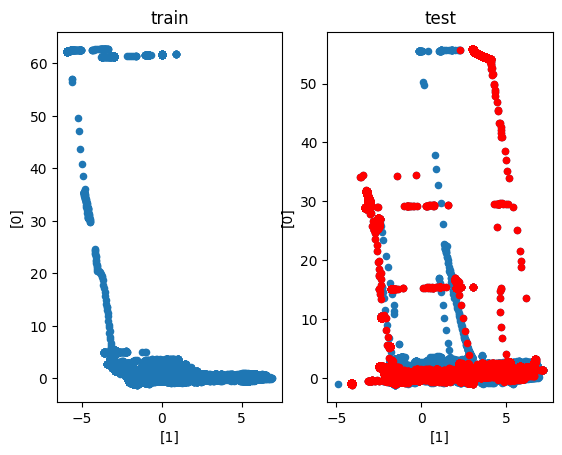

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

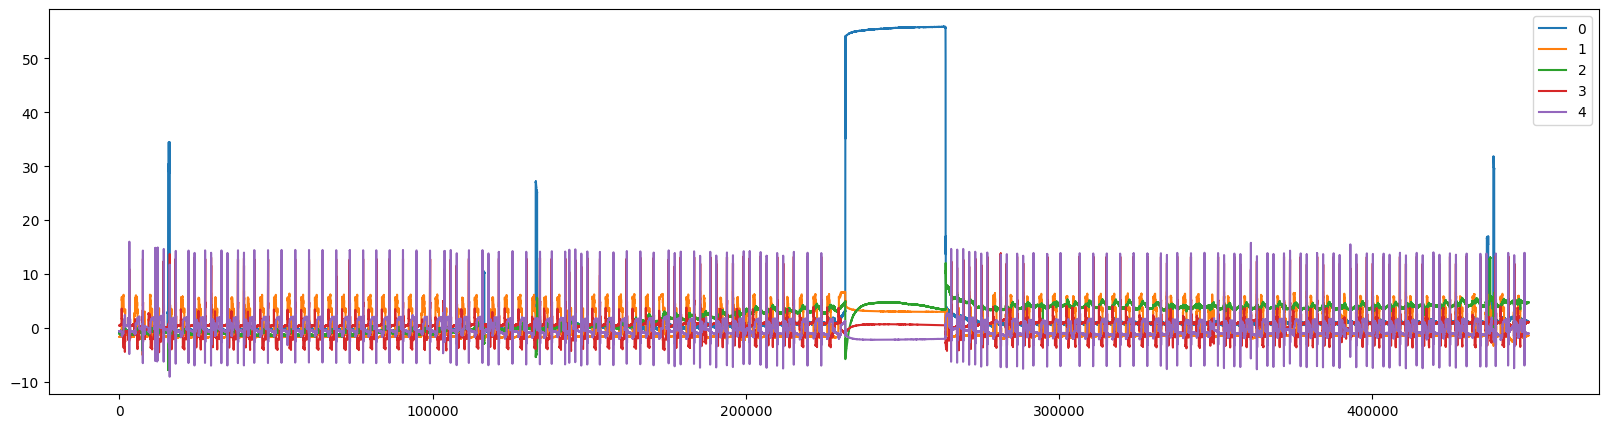

In [18]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [19]:
model = LOF()

2022-09-01 13:13:26.357821: refit model...
Train prediction score statistics
            min: -165.84475342868535
            mean: -1.0546046107230536
            max: -0.8895851184790514


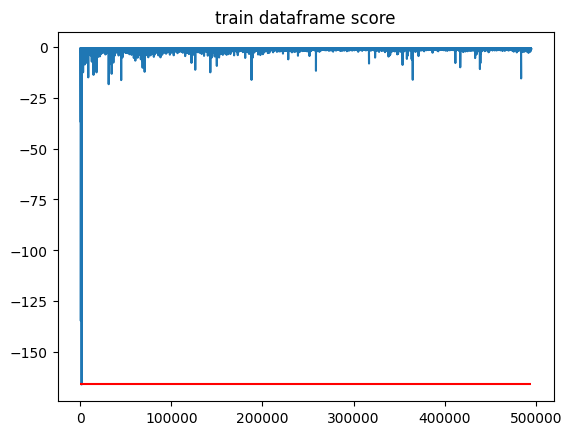

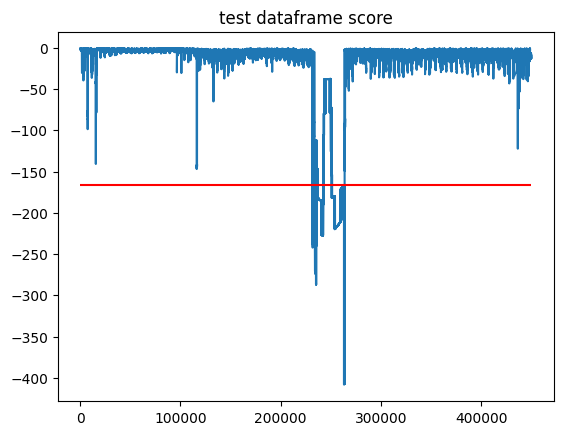

SWATDec15_lof_n5
f1_score: 0.56
accuracy_score: 0.93
precision_score: 1.00
recall_score: 0.39


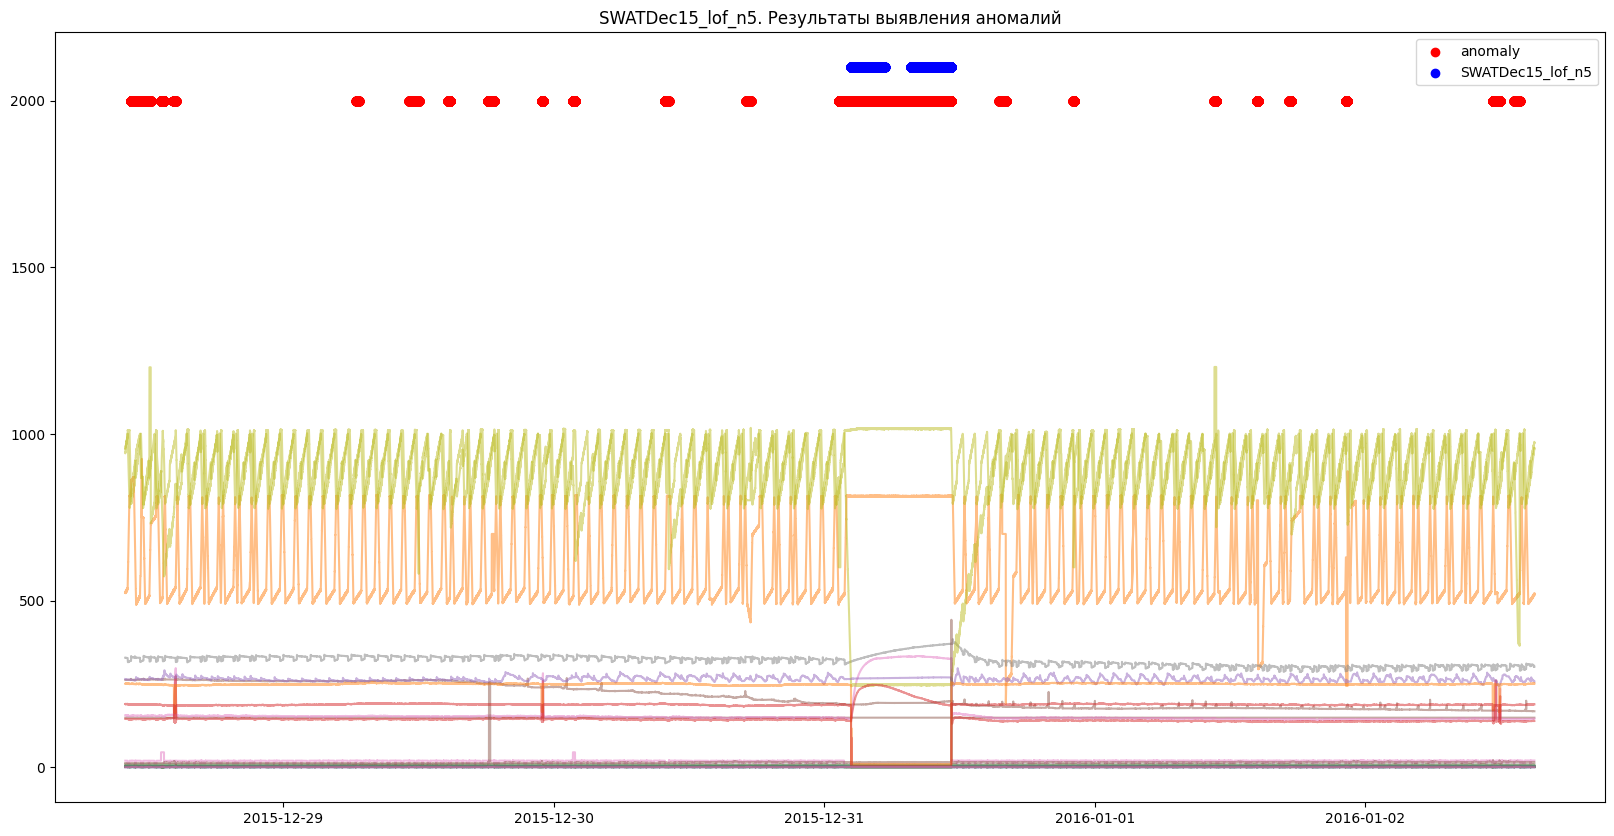

In [20]:
description = f'SWATDec15_lof_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

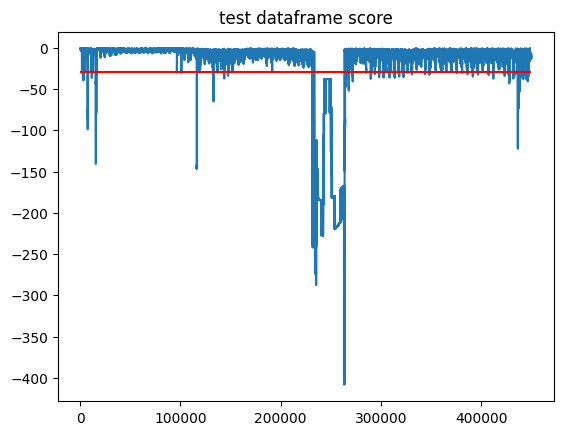

SWATDec15_lof_n5
f1_score: 0.73
accuracy_score: 0.94
precision_score: 0.91
recall_score: 0.60


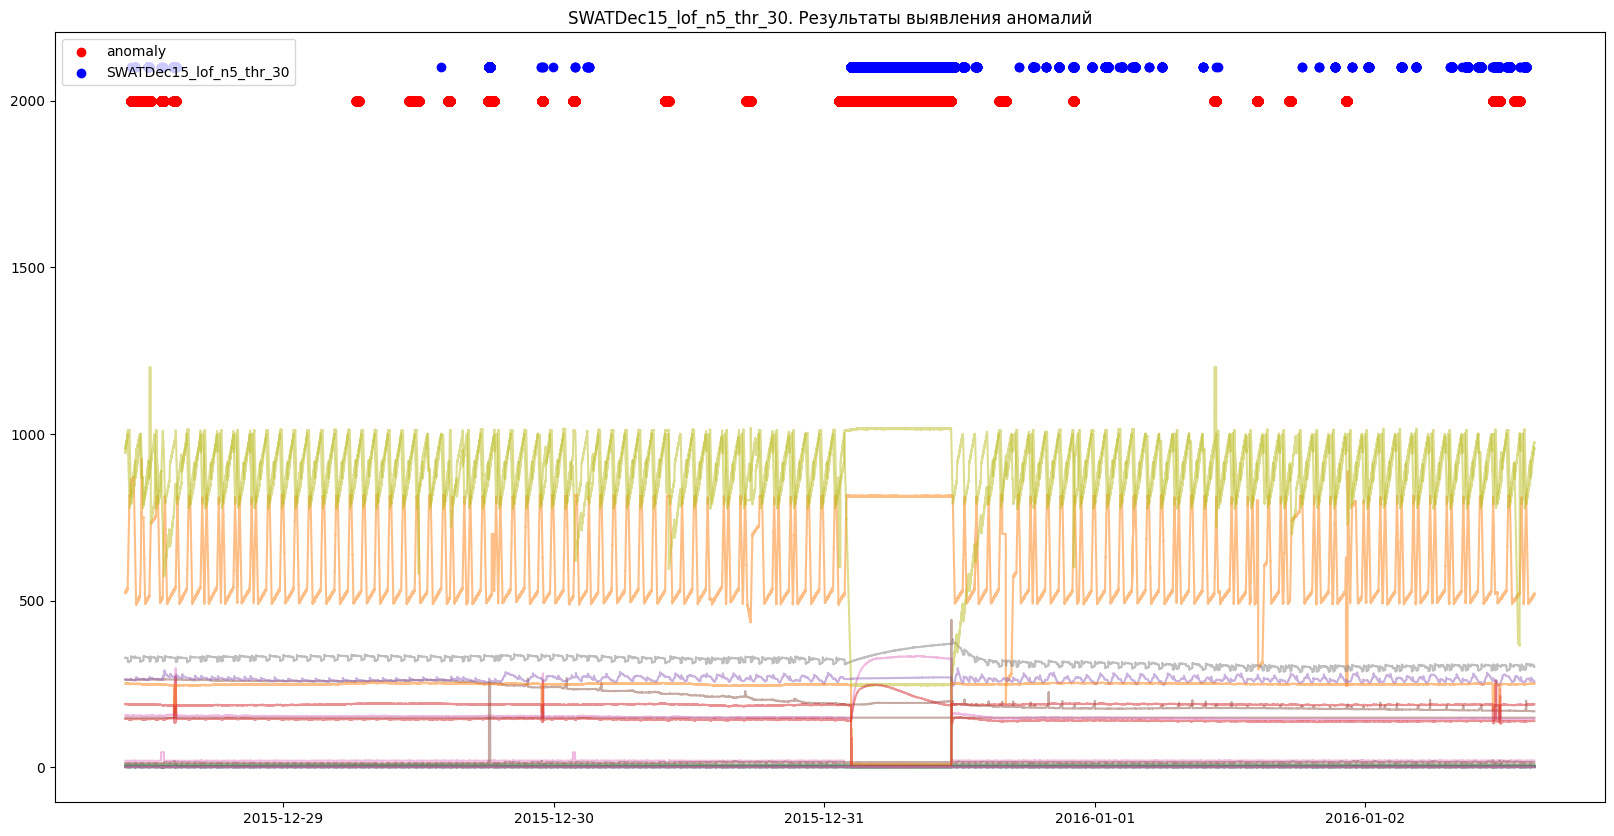

In [21]:
description = f'SWATDec15_lof_n{N_COMPONENTS}_thr_30'

y_pred = predictor.get_anomalies(threshold = -30)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-01 13:14:31.550790: find saved model: ./saved_models/SWATDec15_iF_default, loading...
SWATDec15_iF_default
f1_score: 0.73
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.57


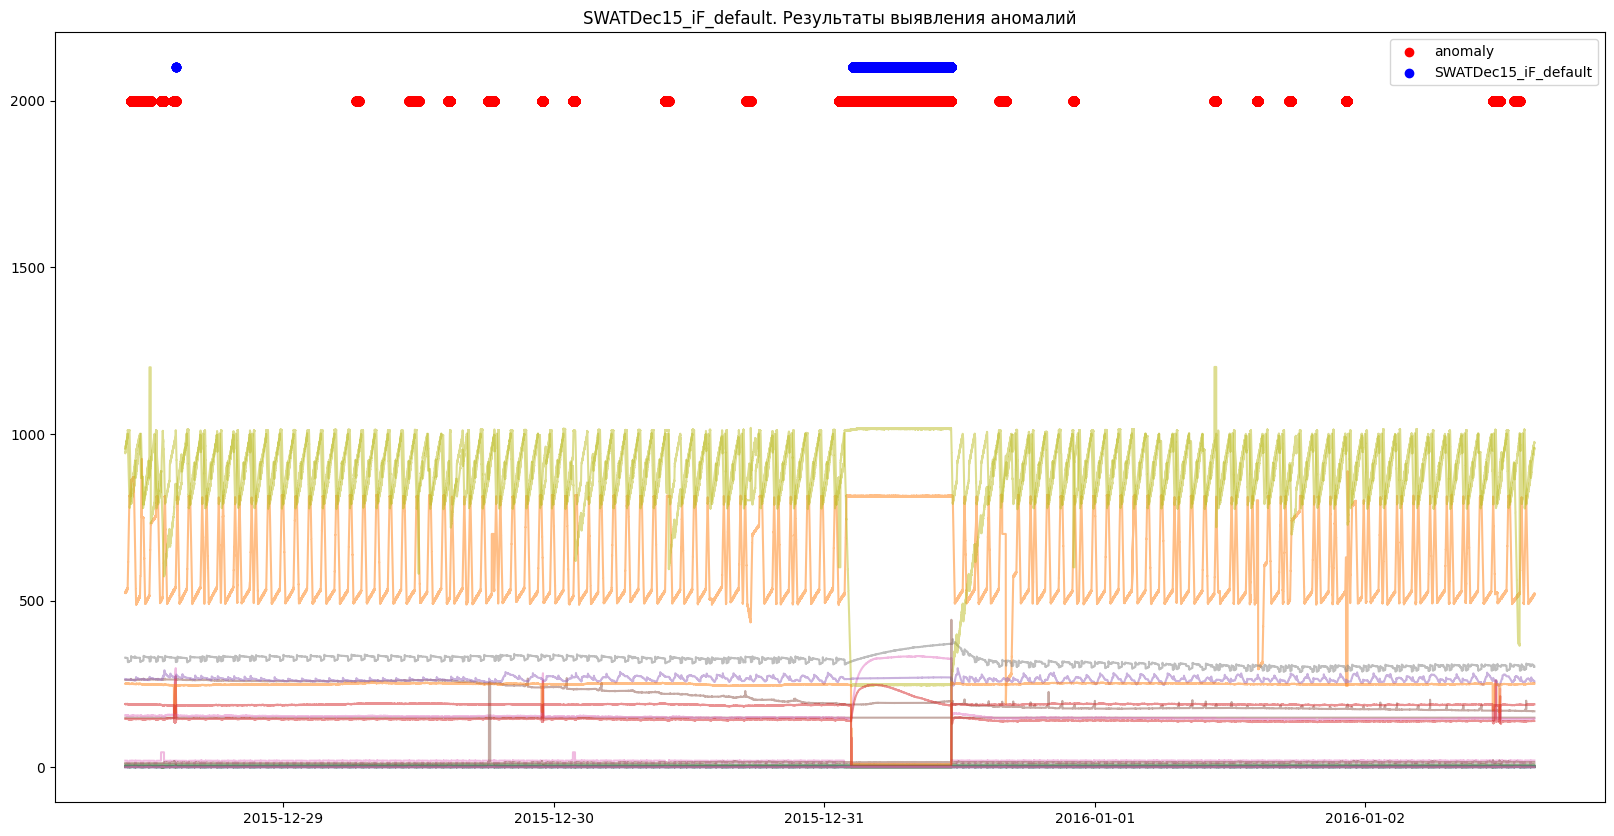

In [22]:
description = f'SWATDec15_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Размеры выборок:
            x_train: (495000, 46)
            x_test: (449919, 46)
            y_test: (449919,)
2022-09-01 13:14:44.337658: refit model...
SWATDec15_iF_n_200_c_0005
f1_score: 0.74
accuracy_score: 0.95
precision_score: 1.00
recall_score: 0.59


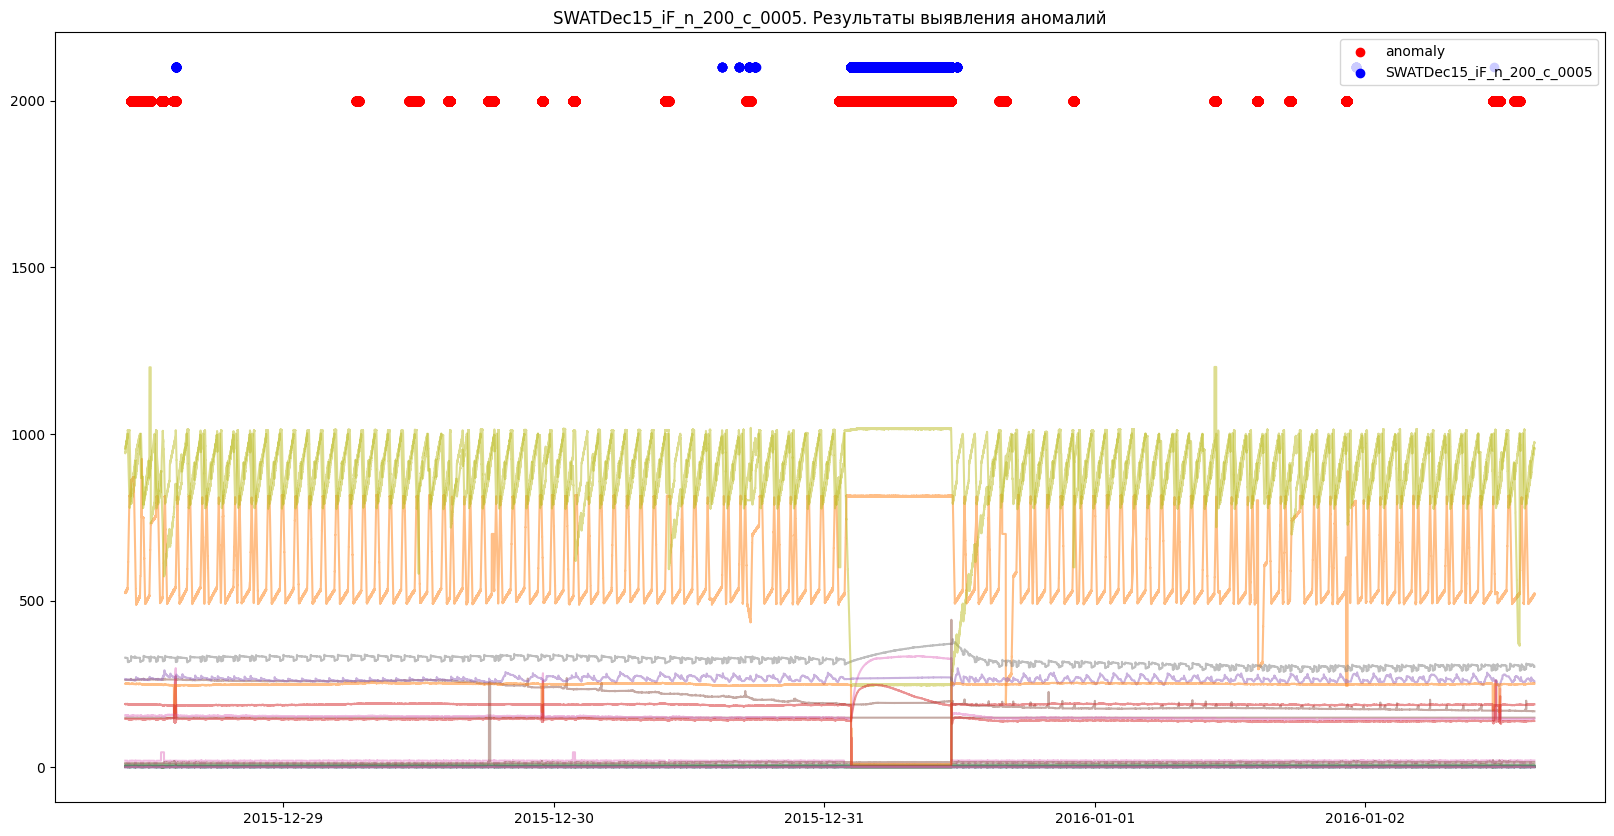

In [23]:
description = f'SWATDec15_iF_n_200_c_0005'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=200, contamination=0.005)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

In [ ]:
window_size = 30
resample_rate = '1T'

description = f'SWATDec15_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 12.1%

Counter({0: 395298, 1: 54621})
Resampling... (1T)
(8250, 46), (7500, 46), (7500,),
Create sequences with window size 30...
Размеры выборок:
            x_train: (494971, 30, 46)
            x_test: (449890, 30, 46)
            y_test: (449890, 30)
2022-09-01 13:17:35.534301: can't find saved model, fit model...


2022-09-01 13:17:38.467894: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2732239920 exceeds 10% of free system memory.
2022-09-01 13:18:59.851243: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2732239920 exceeds 10% of free system memory.


Epoch 1/10
495/495 [==============================] - 81s 164ms/step - loss: 806.1025
Epoch 2/10
495/495 [==============================] - 88s 177ms/step - loss: 143.4945
Epoch 3/10
495/495 [==============================] - 88s 179ms/step - loss: 54.2514
Epoch 4/10
495/495 [==============================] - 88s 178ms/step - loss: 2.1409
Epoch 5/10
495/495 [==============================] - 88s 178ms/step - loss: 1.4015
Epoch 6/10
495/495 [==============================] - 88s 178ms/step - loss: 1.2165
Epoch 7/10
495/495 [==============================] - 87s 176ms/step - loss: 1.1159
Epoch 8/10
495/495 [==============================] - 90s 182ms/step - loss: 1.0490
Epoch 9/10
495/495 [==============================] - 89s 181ms/step - loss: 0.9734
Epoch 10/10
495/495 [==============================] - 80s 161ms/step - loss: 0.9219


2022-09-01 13:34:10.378704: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 2483392800 exceeds 10% of free system memory.


In [1]:
y_pred = predictor.get_anomalies(threshold=800)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description + '_thresh_800')

NameError: name 'predictor' is not defined

In [ ]:
y_pred = predictor.get_anomalies(threshold=400)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description + '_thresh_400')

## SOM

In [ ]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

In [ ]:
description = f'SWATDec15_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

In [ ]:
y_pred = predictor.get_anomalies(threshold=220)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description+'_thresh_220')

# Сводная таблица

In [ ]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format(precision=2).background_gradient(cmap='Blues')

In [ ]:
df_summary.style.format(precision=2).background_gradient(cmap='Blues')